In [1]:
using Pkg
Pkg.activate("../")
Pkg.status()
#Pkg.instantiate()

  Activating environment at `~/Documents/comparison/ina-julia/Project.toml`


      Status `~/Documents/comparison/ina-julia/Project.toml`
  [6e4b80f9] BenchmarkTools v1.1.4
  [a134a8b2] BlackBoxOptim v0.6.0
  [336ed68f] CSV v0.9.0
  [a93c6f00] DataFrames v1.2.2
  [0c46a032] DifferentialEquations v6.18.0
  [587475ba] Flux v0.12.6
  [a75be94c] GalacticOptim v2.0.3
  [7073ff75] IJulia v1.23.2
  [961ee093] ModelingToolkit v6.4.9
  [429524aa] Optim v1.4.1
  [d96e819e] Parameters v0.12.2
  [91a5bcdd] Plots v1.21.3
  [438e738f] PyCall v1.92.3
  [efcf1570] Setfield v0.7.1
  [c3572dad] Sundials v4.5.3


# Load packages

In [2]:
using DifferentialEquations
using Sundials
using DataFrames: DataFrame
using CSV: File as CSVFile

using Plots
using BenchmarkTools

using Parameters
using Setfield

using BlackBoxOptim
using PyCall
so = pyimport("scipy.optimize");

In [3]:
import Pkg

# Load CSV

In [4]:
read_csv(filename) = DataFrame(CSVFile(filename))

read_csv (generic function with 1 method)

In [5]:
dirname_data = "../data"
dirname_legends = joinpath(dirname_data, "legends")
dirname_protocols = joinpath(dirname_data, "protocols")

filename_legend_constants = joinpath(dirname_legends, "legend_constants_v3.csv")
filename_legend_states = joinpath(dirname_legends, "legend_states.csv")
filename_protocol = joinpath(dirname_protocols, "protocol_sparse.csv");

In [6]:
legend_states = read_csv(filename_legend_states)
legend_constants = read_csv(filename_legend_constants)
protocol = read_csv(filename_protocol);

In [7]:
find_step(t, protocol) = protocol.v[findfirst(x -> x >= t, protocol.t)]

function create_p_from_legend(legend)
    name = Symbol.(legend_constants.name)
    value = legend_constants.value
    p = (; zip(name, value)...)
end

create_p_from_legend (generic function with 1 method)

# Load equations

In [8]:
include("../src/models/ina.jl");
include("../src/models/currents.jl");

# Define model

In [9]:
function compute_algebraic(du, u, p, t)
    
    v_comp, v_p, v_m, m, h, j, I_out = u
        
    tau_m  = calculate_tau_m(v_m, p)
    tau_h  = calculate_tau_h(v_m, p)
    tau_j  = calculate_tau_j(v_m, p)
    
    m_inf  = calculate_m_inf(v_m, p)
    h_inf  = calculate_h_inf(v_m, p)
    
    v_cp   = calculate_v_cp(v_comp, p)

    I_leak = 0 # calculate_I_leak(v_m, p)
    I_Na   = calculate_I_Na(v_m, m, h, j, p)
    I_c    = 0 # calculate_I_c(v_m, v_cp, I_leak, I_Na,  p)  # or calculate_I_c(v_m, v_p, I_leak, I_Na,  p)
    I_p    = 0  # or calculate_I_p(v_cp, v_p, p)
    I_comp = 0 # calculate_I_comp(v_comp, p)
    
    I_in   = I_leak + I_Na + I_c - I_comp + I_p
    
    a = (;
     tau_m, tau_h, tau_j, m_inf, h_inf,
     v_cp,
     I_leak, I_Na, I_c, I_comp, I_in
    )
    
end

compute_algebraic (generic function with 1 method)

In [10]:
function compute_rates!(du, u, p, t, safety_factor=0.)
    
    v_comp, v_p, v_m, m, h, j, I_out = u
    
    a = compute_algebraic(du, u, p, t)
    
    du[1] = calculate_d_v_comp(v_comp, p)  # v_comp
    
    @unpack v_cp, I_leak, I_Na = a
    du[2] = 0#calculate_d_v_p(v_cp, v_p, p)  # v_p
    du[3] = calculate_d_v_m(v_m, v_cp, I_leak, I_Na, p)  # v_m
        
    @unpack m_inf, tau_m, h_inf, tau_h, tau_j = a
    du[4] = calculate_d_gate(m_inf, m, tau_m + safety_factor)  # m
    du[5] = calculate_d_gate(h_inf, h, tau_h + safety_factor)  # h
    du[6] = calculate_d_gate(h_inf, j, tau_j)  # j
        
    @unpack I_in = a
    @unpack tau_z = p
    du[7] = calculate_d_gate(I_in, I_out, tau_z)  # I_out
    
    nothing
end

compute_rates! (generic function with 2 methods)

In [11]:
rhs = ODEFunction(compute_rates!, syms=[:v_comp, :v_p, :v_m, :m, :h, :j, :I_out]);

# Callbacks

In [12]:
function change_step_v1!(integrator)
    t = integrator.t
    v_c = find_step(t, protocol)
    integrator.p["v_c"] = v_c
    set_proposed_dt!(integrator, 1e-7)
    nothing
end

cb_step_v1  = PresetTimeCallback(protocol.t, change_step_v1!, save_positions=(false, false));

# Globals

In [13]:
u₀ = [-80.0, -80.0, -80.0, 0.0000001, 0.999999, 0.999999, 0.0];
reltol = 1e-3
abstol = [1e-3, 1e-3, 1e-3, 1e-6, 1e-6, 1e-6, 1e-3]
solver = CVODE_BDF();
tspan_initial = (0., 10.)
tspan = (0., 5.)
saveat = tspan[1]: 5e-5: tspan[2]

0.0:5.0e-5:5.0

# Loss

In [14]:
kwargs_loss_robust = (α=-2, c=0.1)

(α = -2, c = 0.1)

In [15]:
p_dict = Dict(zip(legend_constants.name, legend_constants.value));
p_dict["α"] = kwargs_loss_robust.α

-2

In [16]:
p_keys_opt_m = ["a0_m", "s_m", "b0_m", "delta_m", "v_half_m", "k_m"]
p_keys_opt_h = ["a0_h", "s_h", "b0_h", "delta_h", "v_half_h", "k_h"]
p_keys_opt_j = ["tau_j_const", "a0_j", "s_j", "b0_j", "delta_j"]

p_keys_opt_INa = ["g_max"]

p_keys_opt_other = ["α"]  # loss_robust
p_keys_opt_patch = ["c_p","c_m","R","R_f","g_leak","tau_z","x_c_comp","x_r_comp"]
p_keys_alpha = ["alpha"]

1-element Vector{String}:
 "alpha"

In [17]:
# p_keys_opt = vcat(p_keys_opt_m, p_keys_opt_h, p_keys_opt_j)
p_keys_opt = vcat(p_keys_opt_INa, p_keys_opt_other, p_keys_opt_m, p_keys_opt_h, p_keys_opt_j)#, p_keys_opt_patch, p_keys_alpha)

19-element Vector{String}:
 "g_max"
 "α"
 "a0_m"
 "s_m"
 "b0_m"
 "delta_m"
 "v_half_m"
 "k_m"
 "a0_h"
 "s_h"
 "b0_h"
 "delta_h"
 "v_half_h"
 "k_h"
 "tau_j_const"
 "a0_j"
 "s_j"
 "b0_j"
 "delta_j"

In [18]:
legend_subset = legend_constants[in(p_keys_opt).(legend_constants.name), :]

18×5 DataFrame
 Row │ name         value        bound_1     bound_2     is_log 
     │ InlineSt…    Float64      Float64     Float64     Int64  
─────┼──────────────────────────────────────────────────────────
   1 │ a0_m         16529.1      10000.0     100000.0         1
   2 │ b0_m           386.7        100.0       1000.0         1
   3 │ delta_m         22.823        1.0        100.0         0
   4 │ s_m             12.8321       1.0        100.0         0
   5 │ a0_h             6.26         1.0        100.0         1
   6 │ b0_h         58131.4      10000.0     100000.0         1
   7 │ delta_h         10.2758       1.0        100.0         0
   8 │ s_h             21.62         1.0        100.0         0
   9 │ a0_j             0.6462       0.01         1.0         1
  10 │ b0_j         11358.3       5000.0     100000.0         1
  11 │ delta_j          7.445        1.0        100.0         0
  12 │ s_j             69.417        1.0        100.0         0
  13 │ tau_j_const      0.00132      0.0005       0.005       1
  14 │ g_max         3392.4       1000.0      10000.0         1
  15 │ v_half_m        28.358       10.0         60.0         0
  16 │ v_half_h        59.6912      50.0        100.0         0
  17 │ k_m              7.66677      1.0         10.0         0
  18 │ k_h              5.50777      1.0         10.0         0

In [19]:
mask_log = Dict(zip(legend_constants.name,
                    Array{Bool}(legend_constants.is_log)));
mask_log["α"] = Bool(0)

false

In [20]:
function calculate_loss_robust(x; α=2, c=1)
    if α ≈ 2
        loss = 0.5 * (x / 2)^2
    elseif α ≈ 0
        loss = log((x / c)^2 + 1)
#     elseif α > 1e9
#         loss = 1 - exp(-0.5 * (x / c)^2)
    else
        A = abs(α - 2) / α
        B = ((x / c)^2) / abs(α - 2) + 1
        loss = A * (B^(α / 2) - 1)
    end
end

calculate_loss_robust (generic function with 1 method)

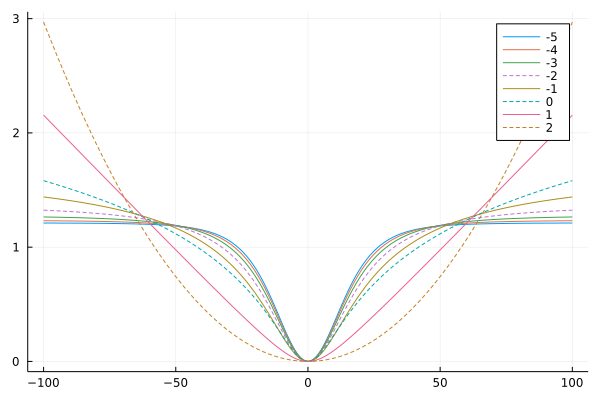

In [21]:
c = 10
α = -2

x = collect(-100 : 1 : 100)

pl = plot()
for α ∈ -5 : 1 : 2
    loss = calculate_loss_robust.(x; α, c)
    loss ./= mean(loss)
    linestyle = α ∈ (2, 0, -2) ? :dash : :solid
    plot!(pl, x, loss, label=α, linestyle=linestyle)
end

display(pl)

In [22]:
function calculate_rmse(x, y)
    se = (x .- y) .^2
    return √mean(se)
end

calculate_rmse (generic function with 1 method)

In [23]:
function prepare_p(x::Vector{Float64})
    
    @assert length(x) == length(p_keys_opt)
    
    p = deepcopy(p_dict)
    for (k, v, is_log) in zip(p_keys_opt, x, mask_log)
        p[k] = mask_log[k] ? exp(v) : v
#         p[k] = v
    end
    
    p["α"] = kwargs_loss_robust.α
    
    return p
    
end

prepare_p (generic function with 1 method)

In [24]:
function solve_model(p)
    prob = ODEProblem(rhs, u₀, tspan, p, callback=cb_step_v1)
    solve_kwargs = (; reltol, abstol, solver, saveat)
    sol = solve(prob; solve_kwargs...)
    return sol
end

solve_model (generic function with 1 method)

In [43]:
    v_m_range = -100:1:50
    tau_m = [calculate_tau_m(k, p) for k in v_m_range]
    tau_h = [calculate_tau_h(k, p) for k in v_m_range]
    
    tau_m_idxmax = findmax(tau_m)[2]
    tau_h_idxmax = findmax(tau_h)[2]

    is_ok = true
    is_ok &= all(1e-6 .< tau_m .< 0.01)
    is_ok &= all(1e-6 .< tau_h .< 0.1)
    
    is_ok &= (-90. < v_m_range[tau_m_idxmax] < 0.)
    is_ok &= (-90. < v_m_range[tau_h_idxmax] < 0.)

false

In [48]:
v_m_range[tau_m_idxmax]

-36

In [49]:
v_m_range[tau_h_idxmax]

-69

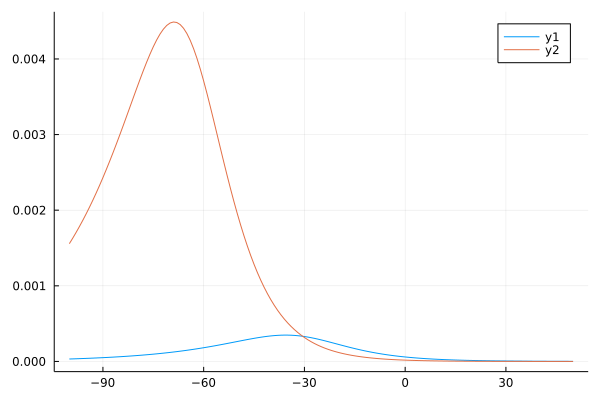

In [47]:
plot(v_m_range, tau_m)
plot!(v_m_range, tau_h)

In [59]:
function sanity_check(p)
    v_m_range = -100:1:50
    tau_m = [calculate_tau_m(k, p) for k in v_m_range]
    tau_h = [calculate_tau_h(k, p) for k in v_m_range]
    
    tau_m_idxmax = findmax(tau_m)[2]
    tau_h_idxmax = findmax(tau_h)[2]

    is_ok = true
    is_ok &= all(1e-9 .< tau_m .< 0.01)
    is_ok &= all(1e-9 .< tau_h .< 0.1)
    
    is_ok &= (-90. < v_m_range[tau_m_idxmax] < 0.)
    is_ok &= (-90. < v_m_range[tau_h_idxmax] < 0.)
    
    return is_ok
end

sanity_check (generic function with 1 method)

In [60]:
function calculate_loss(x)
    
    p = prepare_p(x)
    if !sanity_check(p)
        return Inf
    end
    sol = solve_model(p)
    
    if sol.retcode ≠ :Success
        loss = Inf
    else
        #loss = calculate_rmse(sol[:I_out], data)
        residuals = sol[:I_out] - data
        loss = calculate_loss_robust.(residuals, α=p["α"], c=kwargs_loss_robust.c)
        loss = mean(loss)
    end
    return loss
    
end

calculate_loss (generic function with 1 method)





# Generate data

In [28]:
x₀ = [mask_log[k] ? log.(p_dict[k]) : p_dict[k] for k in p_keys_opt];

In [29]:
mask_log[p_keys_opt[1]] ? log.(p_dict[p_keys_opt[1]]) : p_dict[p_keys_opt[1]]

8.129292914487545

In [30]:
p = prepare_p(x₀)

Dict{WeakRefStrings.InlineString15, Float64} with 31 entries:
  "g_max"       => 3392.4
  "s_m"         => 12.8321
  "b0_j"        => 11358.3
  "tau_z"       => 0.000100034
  "k_m"         => 7.66677
  "b0_h"        => 58131.4
  "v_half_h"    => 59.6912
  "tau_j_const" => 0.00132
  "c_m"         => 2.47302e-11
  "s_j"         => 69.417
  "v_off"       => -2.0
  "R_f"         => 3.26421e5
  "c_p"         => 4.50296e-13
  "s_h"         => 21.62
  "k_h"         => 5.50777
  "x_c_comp"    => 0.01
  "alpha"       => 0.75
  "v_rev"       => 18.0
  "α"           => -2.0
  "v_half_m"    => 28.358
  "delta_h"     => 10.2758
  "x_r_comp"    => 0.2
  "v_c"         => -80.0
  "g_leak"      => 0.481244
  "delta_m"     => 22.823
  ⋮             => ⋮

In [31]:
sol = solve_model(p);

In [32]:
v_m_test = [k[3] - 18.0 for k in sol.u]
m_test = [k[4] for k in sol.u]
h_test = [k[5] for k in sol.u]
j_test = [k[6] for k in sol.u]
I_Na = [(p["g_max"]*(v_m_test[k] - p["v_rev"])*(m_test[k]^3)*h_test[k]*j_test[k]) for k in 1:length(m_test)];

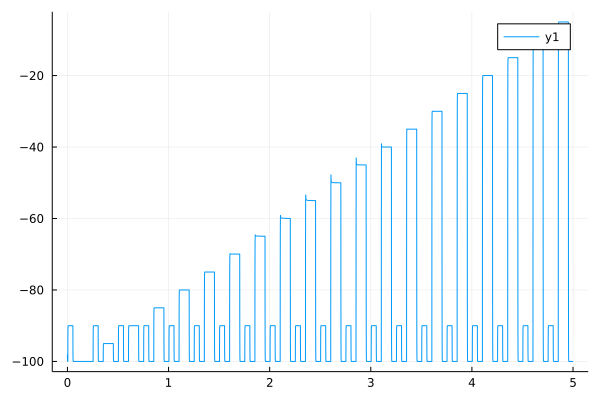

In [33]:
plot(sol.t,v_m_test)

In [34]:
data = copy(sol[:I_out]);

In [35]:
calculate_loss(x₀)

Inf

In [36]:
sanity_check(p)

false

# Test model

In [924]:
# remake(prob, p=p)

In [37]:
bounds = []

for key ∈ p_keys_opt
    if key == "α"
        append!(bounds, [(-5., 0.)])
        continue
    end
    idx = findfirst(legend_subset.name .== key)
    lb, ub = legend_subset.bound_1[idx], legend_subset.bound_2[idx]
    b = (lb, ub)
    if mask_log[key]
        b = map(x -> log.(x), b)
    end
    append!(bounds, [b])
end

In [38]:
x_initial = [b[1] + rand() * (b[2] - b[1]) for b in bounds];
p_initial = prepare_p(x_initial)

prob = ODEProblem(rhs, u₀, tspan, p_initial, callback=cb_step_v1)
solve_kwargs = (; reltol, abstol, solver)
sol = solve(prob; solve_kwargs...);


In [39]:
print(p_initial)

Dict{WeakRefStrings.InlineString15, Float64}("g_max" => 7299.375137927461, "s_m" => 81.95240096796994, "b0_j" => 5650.775727515702, "tau_z" => 0.000100034, "k_m" => 8.1202261092159, "b0_h" => 38678.8239389406, "v_half_h" => 57.097751465610216, "tau_j_const" => 0.001140913830215523, "c_m" => 2.473016e-11, "s_j" => 61.49181967844552, "v_off" => -2.0, "R_f" => 326421.4, "c_p" => 4.502963e-13, "s_h" => 58.829629085697064, "k_h" => 6.948390031069709, "x_c_comp" => 0.01, "alpha" => 0.75, "v_rev" => 18.0, "α" => -2.0, "v_half_m" => 32.575457450073785, "delta_h" => 1.9831118230815654, "x_r_comp" => 0.2, "v_c" => -80.0, "g_leak" => 0.4812443, "delta_m" => 98.33678346395381, "a0_j" => 0.018903657460806415, "a0_m" => 33537.10249984194, "delta_j" => 93.84016051937937, "R" => 2.494677e7, "a0_h" => 4.220433014798187, "b0_m" => 369.71261336080215)

# Optimize

In [67]:
bounds = Vector{Tuple{Float64, Float64}}(bounds)

19-element Vector{Tuple{Float64, Float64}}:
 (6.907755278982137, 9.210340371976184)
 (-5.0, 0.0)
 (9.210340371976184, 11.512925464970229)
 (1.0, 100.0)
 (4.605170185988092, 6.907755278982137)
 (1.0, 100.0)
 (10.0, 60.0)
 (1.0, 10.0)
 (0.0, 4.605170185988092)
 (1.0, 100.0)
 (9.210340371976184, 11.512925464970229)
 (1.0, 100.0)
 (50.0, 100.0)
 (1.0, 10.0)
 (-7.600902459542082, -5.298317366548036)
 (-4.605170185988091, 0.0)
 (1.0, 100.0)
 (8.517193191416238, 11.512925464970229)
 (1.0, 100.0)

In [68]:
using BlackBoxOptim: num_func_evals

In [69]:
rhs = ODEFunction((du, u, p, t) -> compute_rates!(du, u, p, t, 1e-6),
                  syms=[:v_comp, :v_p, :v_m, :m, :h, :j, :I_out]);

In [70]:
res = bboptimize(calculate_loss; SearchRange=bounds, MaxTime=1 * 60., TraceInterval=10,
                  PopulationSize=100,
                 );

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.17 secs, 147 evals, 86 steps, improv/step: 0.965 (last = 0.9651), fitness=0.298990555
20.57 secs, 344 evals, 246 steps, improv/step: 0.931 (last = 0.9125), fitness=0.298446881
30.71 secs, 518 evals, 411 steps, improv/step: 0.881 (last = 0.8061), fitness=0.278897695
40.90 secs, 706 evals, 590 steps, improv/step: 0.839 (last = 0.7430), fitness=0.194585428
50.95 secs, 838 evals, 722 steps, improv/step: 0.817 (last = 0.7197), fitness=0.194585428

Optimization stopped after 823 steps and 60.25 seconds
Termination reason: Max time (60.0 s) reached
Steps per second = 13.66
Function evals per second = 15.62
Improvements/step = Inf
Total function evaluations = 941


Best candidate found: [7.16236, -2.11102, 9.76557, 41.3082, 5.24591, 31.5813, 22.922, 9.46435, 4.3667, 13.1121, 10.2613, 24.084

In [71]:
x_bbo = best_candidate(res);
x_best = copy(x_bbo);

In [72]:
res = so.minimize((x, args) -> calculate_loss(x), x_best, bounds,
                  method="Nelder-Mead", options=Dict(:maxiter => 100))

Dict{Any, Any} with 8 entries:
  "fun"           => 0.16528
  "nit"           => 100
  "nfev"          => 167
  "status"        => 2
  "success"       => false
  "message"       => "Maximum number of iterations has been exceeded."
  "x"             => [7.26358, -2.1004, 10.0768, 41.8482, 5.3531, 31.4466, 23.2…
  "final_simplex" => ([7.26358 -2.1004 … 9.6399 27.1358; 7.27692 -2.09181 … 9.6…

In [73]:
x_best = res["x"]

19-element Vector{Float64}:
  7.263577642719541
 -2.100403324296744
 10.076802024169389
 41.84820277355948
  5.353096618671792
 31.446578311393765
 23.29673425008115
  9.467870650435458
  4.537494527991196
 13.354857104045784
 10.209821306379357
 23.760392660463495
 54.57472321220706
  5.495543724737978
 -7.166859012759666
 -4.505814053320631
 89.82690184420045
  9.639895686622776
 27.13576480599724

In [74]:
# res = so.minimize((x, args) -> calculate_loss(x), x_best, bounds, method="Nelder-Mead", options=Dict(:maxiter => 1000))

In [80]:
lb = [b[1] for b in bounds]
ub = [b[2] for b in bounds];

In [81]:
df = DataFrame(Name = p_keys_opt,
          True = x₀,
          Lb = lb,
          Best = x_best,
          Ub = ub);
# df[:, 2:end] = exp.(df[:, 2:end]);
df.relerr = (df.Best - df.True) ./ df.Best * 100.;

In [82]:
df

19×6 DataFrame
 Row │ Name         True       Lb        Best      Ub         relerr     
     │ String       Float64    Float64   Float64   Float64    Float64    
─────┼───────────────────────────────────────────────────────────────────
   1 │ g_max         8.12929    6.90776   7.26358    9.21034  -11.9186
   2 │ α            -2.0       -5.0      -2.1004     0.0        4.78019
   3 │ a0_m          9.71288    9.21034  10.0768    11.5129     3.61153
   4 │ s_m          12.8321     1.0      41.8482   100.0       69.3366
   5 │ b0_m          5.95765    4.60517   5.3531     6.90776  -11.2935
   6 │ delta_m      22.823      1.0      31.4466   100.0       27.4229
   7 │ v_half_m     28.358     10.0      23.2967    60.0      -21.7253
   8 │ k_m           7.66677    1.0       9.46787   10.0       19.0233
   9 │ a0_h          1.83418    0.0       4.53749    4.60517   59.5772
  10 │ s_h          21.62       1.0      13.3549   100.0      -61.8887
  11 │ b0_h         10.9705     9.21034  10.2098    11.5129    -7.45008
  12 │ delta_h      10.2758     1.0      23.7604   100.0       56.7523
  13 │ v_half_h     59.6912    50.0      54.5747   100.0       -9.37512
  14 │ k_h           5.50777    1.0       5.49554   10.0       -0.222494
  15 │ tau_j_const  -6.63012   -7.6009   -7.16686   -5.29832    7.48913
  16 │ a0_j         -0.436646  -4.60517  -4.50581    0.0       90.3093
  17 │ s_j          69.417      1.0      89.8269   100.0       22.7214
  18 │ b0_j          9.3377     8.51719   9.6399    11.5129     3.13479
  19 │ delta_j       7.445      1.0      27.1358   100.0       72.5639

In [75]:
calculate_loss(x_bbo), calculate_loss(x_best)

(0.194585428282554, 0.1652796798833554)

In [76]:
sol_best = solve_model(prepare_p(x_best));

In [99]:
plot(sol_best, vars=[:I_out])
plot!(sol_best.t .- 2e-2, data)
plot!(ylims=(-5, 0.5))

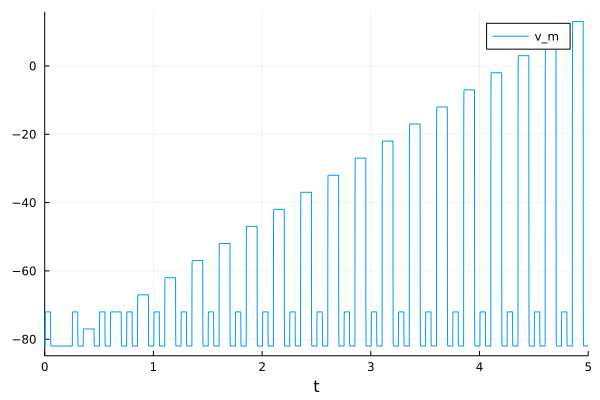

In [100]:
plot(sol_best, vars=[:v_m])

In [84]:
v_m = (-100:10)

-100:10

In [85]:
Tau_m  = [calculate_tau_m(k, p) for k in v_m]
Tau_h  = [calculate_tau_h(k, p) for k in v_m]
Tau_j  = [calculate_tau_j(k, p) for k in v_m]

M_inf  = [calculate_m_inf(k, p) for k in v_m]
H_inf  = [calculate_h_inf(k, p) for k in v_m];

In [87]:
p_best = prepare_p(x_best);

In [88]:
tau_m  = [calculate_tau_m(k, p_best) for k in v_m]
tau_h  = [calculate_tau_h(k, p_best) for k in v_m]
tau_j  = [calculate_tau_j(k, p_best) for k in v_m]

m_inf  = [calculate_m_inf(k, p_best) for k in v_m]
h_inf  = [calculate_h_inf(k, p_best) for k in v_m];

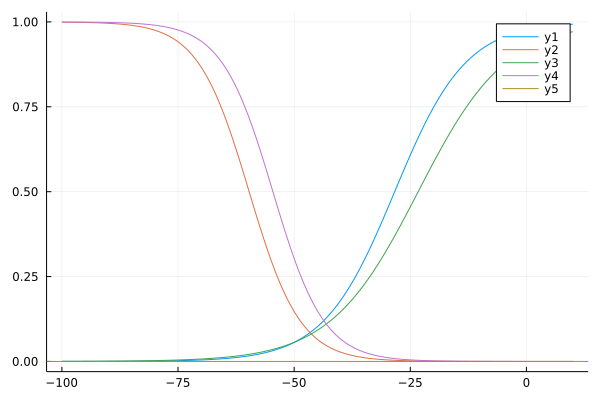

In [103]:
plot(v_m, M_inf)
plot!(v_m, H_inf)

plot!(v_m, m_inf)
plot!(v_m, h_inf)

hline!([0.])

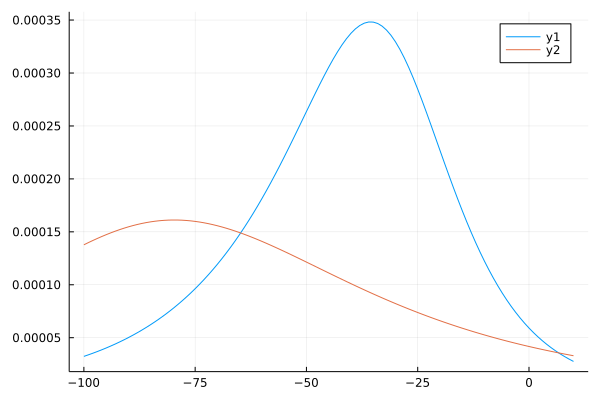

In [93]:
plot(v_m, Tau_m)
plot!(v_m, tau_m)

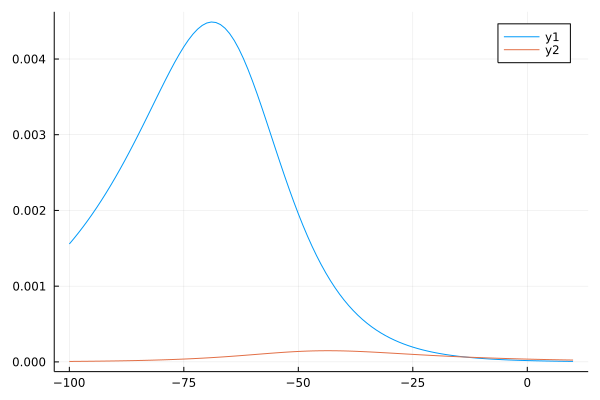

In [94]:
plot(v_m, Tau_h)
plot!(v_m, tau_h)

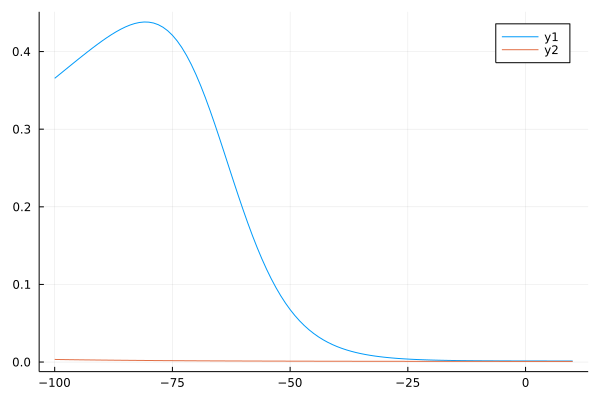

In [104]:
plot(v_m, Tau_j)
plot!(v_m, tau_j)

In [257]:
data_for_test = read_csv("../../INa_full_trace/data/training/2020_12_21_0007.csv");

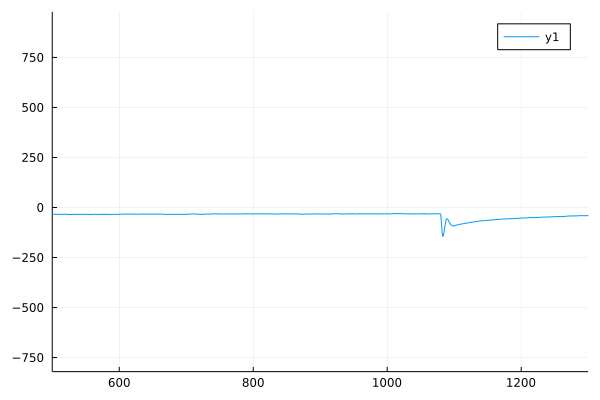

In [261]:
plot(data_for_test.I_out)
plot!(xlims = (500, 1300))

In [170]:
plot(sol_best.t, calculate_loss_robust.(residuals,
                                         c=0.1, #kwargs_loss_robust.c,
                                         α=-3, #p_best["α"]
                                        ))

plot!(sol_best.t, calculate_loss_robust.(residuals,
                                         c=kwargs_loss_robust.c,
                                         α=p_best["α"]
                                        ))

LoadError: UndefVarError: residuals not defined

# Test unstable sol

In [108]:
x_initial = [b[1] + rand() * (b[2] - b[1]) for b in bounds];

In [121]:
st = :Success

while st == :Success
    x_rand = [b[1] + rand() * (b[2] - b[1]) for b in bounds];

    p_rand = prepare_p(x_rand)
    if !sanity_check(p_rand)
        continue
    end
    sol_best = solve_model(p_rand)
    st = sol_best.retcode
end

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/nik/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:351


In [122]:
sol_best = solve_model(p_rand);

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/nik/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:351


In [123]:
sanity_check(p_rand)

true

In [124]:
function euler_step(u, du, dt)
    @. u + dt * du
end

euler_step (generic function with 1 method)

In [125]:
du = zeros(size(u₀))
t = 0.
dt = 1e-9

compute_rates!(du, u₀, p_rand, t)

In [126]:
du

7-element Vector{Float64}:
     0.0
     0.0
 -3241.8188743330375
    -0.001745355753884301
   -74.12086952352222
    -1.2462125438149578
    -3.079115455523512e-12

In [127]:
euler_step(u₀, du, 1e-9)

7-element Vector{Float64}:
 -80.0
 -80.0
 -80.00000324181887
   9.999825464424611e-8
   0.9999989258791304
   0.9999989987537874
  -3.0791154555235123e-21

In [766]:
v_m_range = -100 : 10

tau_m = [calculate_tau_m(v_m, p_rand) for v_m in v_m_range]

Tau_m = [calculate_tau_m(v_m, p) for v_m in v_m_range]

111-element Vector{Float64}:
 3.233324237015441e-5
 3.37804683389671e-5
 3.529234128027613e-5
 3.68717254693292e-5
 3.8521607855152605e-5
 4.024510254645947e-5
 4.204545531772486e-5
 4.392604810406658e-5
 4.5890403446448974e-5
 4.79421888402899e-5
 5.008522093056724e-5
 5.2323469484724535e-5
 5.4661061060760856e-5
 ⋮
 6.371906729636154e-5
 5.9116468902372715e-5
 5.482815317884186e-5
 5.08359136599073e-5
 4.71219969906275e-5
 4.366921875894901e-5
 4.046104752162281e-5
 3.7481662564738455e-5
 3.471599021218305e-5
 3.214972281572852e-5
 2.976932394092366e-5
 2.7562022708903397e-5

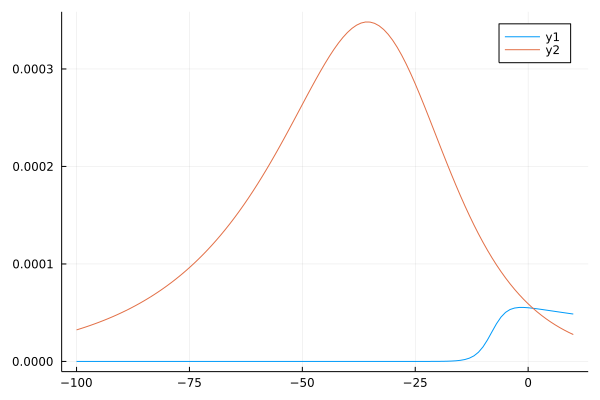

In [768]:
plot(v_m_range, (tau_m))
plot!(v_m_range, (Tau_m))

In [106]:
prob = ODEProblem(rhs, u₀, tspan, p_rand, callback=cb_step_v1)
solve_kwargs = (; reltol, abstol, solver)
sol = solve(prob; solve_kwargs...)

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/nik/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:351


retcode: Unstable
Interpolation: automatic order switching interpolation
t: 1-element Vector{Float64}:
 0.0
u: 1-element Vector{Vector{Float64}}:
 [-80.0, -80.0, -80.0, 1.0e-7, 0.999999, 0.999999, 0.0]

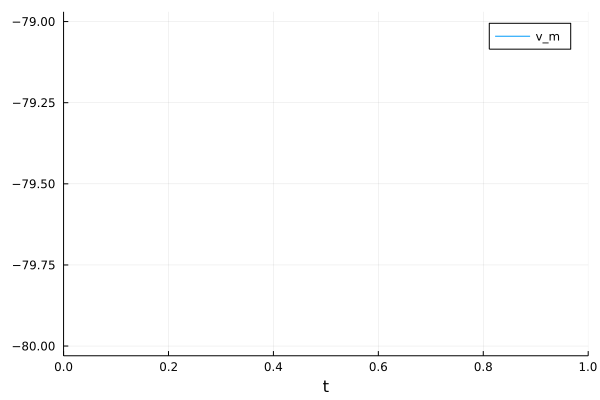

In [107]:
plot(sol, vars=[:v_m])

# Monte Carlo

In [65]:
n_inside = 0
n_total = 100_000

for i in 1:n_total    
    x_rand = [b[1] + rand() * (b[2] - b[1]) for b in bounds]
    p_rand = prepare_p(x_rand)
    n_inside += sanity_check(p_rand)
end

In [66]:
n_inside / n_total * 100

7.519000000000001